In [146]:
import sympy as sp
import numpy as np
import math
from scipy.optimize import brentq, fsolve

In [147]:
g_num = 9.81
h_num = 35.0
H_num = 150.0
D_num = 8.0
t_num = 0.1

M_num = 1.0e6
J_num = 1.6e9
c_num = 30e3

E_num = 210e9
rho_num = 7850.0
rho_f_num = 1025.0
Ca_num = 1.0
Cm_num = 1 + Ca_num
T_num = M_num * g_num

Di_num = D_num - 2.0*t_num
A_num = math.pi/4.0 * (D_num**2 - Di_num**2)
I_num = math.pi/64.0 * (D_num**4 - Di_num**4)

In [148]:
# -----------------------------
# Symbols
# -----------------------------
z, w = sp.symbols('z wega', real=True)
E, I, T = sp.symbols('E I T', positive=True, real=True)
rho, A = sp.symbols('rho A', positive=True, real=True)
rho_f, Ca, D = sp.symbols('rho_f Ca D', positive=True, real=True)
h, H = sp.symbols('h H', positive=True, real=True)
J, Mtip, c = sp.symbols('J M c', real=True)  
EI = E*I

# Effective mass per length (submerged) and (above water)
m1 = rho*A + rho_f*Ca*sp.pi*D**2/4   # submerged
m2 = rho*A                           # above water

# Spatial ODE parameters
beta1_4 = (w**2 * m1) / EI
beta2_4 = (w**2 * m2) / EI

# Define alpha^2 and mu^2 exactly as in your derivation
alpha1_sq = (-T/EI + sp.sqrt((T/EI)**2 + 4*beta1_4))/2
mu1_sq    = ( T/EI + sp.sqrt((T/EI)**2 + 4*beta1_4))/2

alpha2_sq = (-T/EI + sp.sqrt((T/EI)**2 + 4*beta2_4))/2
mu2_sq    = ( T/EI + sp.sqrt((T/EI)**2 + 4*beta2_4))/2

alpha1, mu1 = sp.sqrt(alpha1_sq), sp.sqrt(mu1_sq)
alpha2, mu2 = sp.sqrt(alpha2_sq), sp.sqrt(mu2_sq)

# -----------------------------
# General solutions W1(z), W2(z)
# -----------------------------
A1,B1,C1,D1 = sp.symbols('A1 B1 C1 D1')
A2,B2,C2,D2 = sp.symbols('A2 B2 C2 D2')

W1 = A1*sp.cosh(alpha1*z) + B1*sp.sinh(alpha1*z) + C1*sp.cos(mu1*z) + D1*sp.sin(mu1*z)
W2 = A2*sp.cosh(alpha2*z) + B2*sp.sinh(alpha2*z) + C2*sp.cos(mu2*z) + D2*sp.sin(mu2*z)

# Derivatives you will need for beam BCs
W1_1 = sp.diff(W1, z)
W1_2 = sp.diff(W1, z, 2)
W1_3 = sp.diff(W1, z, 3)

W2_1 = sp.diff(W2, z)
W2_2 = sp.diff(W2, z, 2)
W2_3 = sp.diff(W2, z, 3)

W2_t1 = sp.diff(W2, 't')
w2_t2 = sp.diff(W2, 't', 2)

# Beam resultants (Euler-Bernoulli with axial tension T):
# Mwent:   M = EI * W''
# Shear:    V = EI * W''' + T * W'
M1 = EI*W1_2
V1 = EI*W1_3 + T*W1_1

M2 = EI*W2_2
V2 = EI*W2_3 + T*W2_1



### Define the boundary conditions and constant vector, form the frequency matrix with only no values assigned to variables

In [149]:
# 8 boundary/interface equations (LHS = 0 vorm)
eq1 = W1.subs(z, -h)                        # w1(-h)=0
eq2 = W1_1.subs(z, -h)                      # w1'(-h)=0

eq3 = W1.subs(z, 0)  - W2.subs(z, 0)        # w1(0)=w2(0)
eq4 = W1_1.subs(z, 0) - W2_1.subs(z, 0)     # w1'(0)=w2'(0)
eq5 = W1_2.subs(z, 0) - W2_2.subs(z, 0)     # w1''(0)=w2''(0)
eq6 = W1_3.subs(z, 0) - W2_3.subs(z, 0)     # w1'''(0)=w2'''(0)

# Top BCs at z=H with harmonic time dependence w(z,t)=W(z)*exp(i*w*t)
# EI w2_zz + J w2_ttz = 0  -> EI*W2'' - J*w^2*W2' = 0
eq7 = EI*W2_2.subs(z, H) - J*w2_t2*W2_1.subs(z, H)

# EI w2_zzz + M w2_tt + c w2_t = 0
# -> EI*W2''' - M*w^2*W2 + i*c*w*W2 = 0
eq8 = EI*W2_3.subs(z, H) - Mtip*w2_t2.subs(z, H) + c*W2_t1.subs(z, H)

# Collect them
eqs = [eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8]

# Unknown constants vector
Cvec = sp.Matrix([A1,B1,C1,D1,A2,B2,C2,D2])

# Build K(w) by extracting coefficients of the constants
K = sp.Matrix([[sp.diff(expr, cst) for cst in Cvec] for expr in eqs])
print("K(w) matrix:")
print(K)

K(w) matrix:
Matrix([[cosh(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))), -sinh(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))), cos(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 + T/(2*E*I))), -sin(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 + T/(2*E*I))), 0, 0, 0, 0], [-sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))*sinh(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))), sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))*cosh(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 - T/(2*E*I))), sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 + T/(2*E*I))*sin(h*sqrt(sqrt(4*wega**2*(A*rho + pi*Ca*D**2*rho_f/4)/(E*I) + T**2/(E**2*I**2))/2 + T/(2*E*I))), s

### Assign values to variables

In [150]:
vals = {
    E: E_num,
    I: I_num,
    T: T_num,
    rho: rho_num,
    A: A_num,
    rho_f: rho_f_num,
    Ca: Ca_num,
    D: D_num,
    h: h_num,
    H: H_num,
    J: J_num,
    Mtip: M_num,
    c: 0.0
}

### Make the frequency matrix and extract the natural frequencies

In [151]:
# Numerieke determinantfunctie (snel)
K_w = K.subs(vals)
K_func = sp.lambdify(w, K_w, modules='numpy')

def detK_numeric(omega):
    # Support both real and complex omega inputs
    try:
        K_eval = np.array(K_func(omega), dtype=np.complex128)
    except Exception:
        # Fallback: try using real part (for lambdify implementations that fail on complex)
        K_eval = np.array(K_func(float(np.real(omega))), dtype=np.complex128)
    return np.linalg.det(K_eval)

# Voor ongedempte case (c=0) is det(K) reëel op numerieke ruis na
f = lambda om: float(np.real(detK_numeric(om)))

# Zoekgebied en resolutie (pas aan indien nodig)
omega_min, omega_max = 0, 40
n_scan = 2000
omega_grid = np.linspace(omega_min, omega_max, n_scan)
f_grid = np.array([f(om) for om in omega_grid])

# Bracketing op tekenwisselingen + root finding
roots = []
for i in range(len(omega_grid) - 1):
    a, b = omega_grid[i], omega_grid[i + 1]
    fa, fb = f_grid[i], f_grid[i + 1]

    if np.isfinite(fa) and abs(fa) < 1e-8:
        roots.append(a)
        continue

    if np.isfinite(fa) and np.isfinite(fb) and fa * fb < 0:
        try:
            r = brentq(f, a, b, maxiter=200)
            roots.append(r)
        except ValueError:
            pass

# Dubbels verwijderen (door aangrenzende brackets)
roots = np.array(sorted(roots))
if roots.size > 0:
    unique_roots = [roots[0]]
    for r in roots[1:]:
        if abs(r - unique_roots[-1]) > 1e-4:
            unique_roots.append(r)
    omega_n = np.array(unique_roots)


print(f'The roots and therefore natural frequencies are: {omega_n}')
print('Gevonden omega [rad/s] waarvoor det(K)=0:')

# Controle: determinantwaarde op roots
for r in omega_n:
    print(f'omega={r:.6f}, det={detK_numeric(r)}')


The roots and therefore natural frequencies are: [ 1.48746533  9.12497622 23.75242512]
Gevonden omega [rad/s] waarvoor det(K)=0:
omega=1.487465, det=(2.7576559767245546e-11+0j)
omega=9.124976, det=(2.3148877418316743e-05+0j)
omega=23.752425, det=(-1.3307144367582884+0j)


<lambdifygenerated-62>:2: RuntimeWarning: invalid value encountered in sqrt
  return array([[cosh(35.0*sqrt((1/2)*sqrt(9.83625899053746e-13*wega**2*(19482.5868412371 + 16400.0*pi) + 5.81939642139719e-12) - 1.20617125871466e-6)), -sinh(35.0*sqrt((1/2)*sqrt(9.83625899053746e-13*wega**2*(19482.5868412371 + 16400.0*pi) + 5.81939642139719e-12) - 1.20617125871466e-6)), cos(35.0*sqrt((1/2)*sqrt(9.83625899053746e-13*wega**2*(19482.5868412371 + 16400.0*pi) + 5.81939642139719e-12) + 1.20617125871466e-6)), -sin(35.0*sqrt((1/2)*sqrt(9.83625899053746e-13*wega**2*(19482.5868412371 + 16400.0*pi) + 5.81939642139719e-12) + 1.20617125871466e-6)), 0, 0, 0, 0], [-sqrt((1/2)*sqrt(9.83625899053746e-13*wega**2*(19482.5868412371 + 16400.0*pi) + 5.81939642139719e-12) - 1.20617125871466e-6)*sinh(35.0*sqrt((1/2)*sqrt(9.83625899053746e-13*wega**2*(19482.5868412371 + 16400.0*pi) + 5.81939642139719e-12) - 1.20617125871466e-6)), sqrt((1/2)*sqrt(9.83625899053746e-13*wega**2*(19482.5868412371 + 16400.0*pi) + 5.8193964

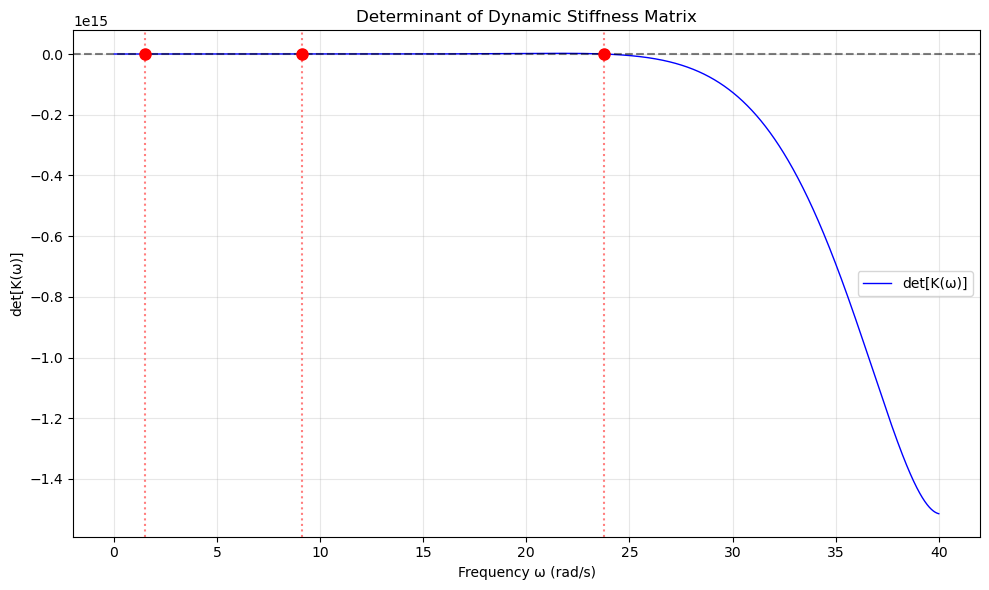

Found 3 natural frequencies
Found complex roots: [ 5.81044698e-14-9.12810077e-03j -2.71552015e-15+9.12810077e-03j
  7.52868431e-10+1.21451550e-28j  1.48746533e+00+0.00000000e+00j
  2.87963200e-13+1.74261193e-02j -8.72246739e-14-1.74261193e-02j]


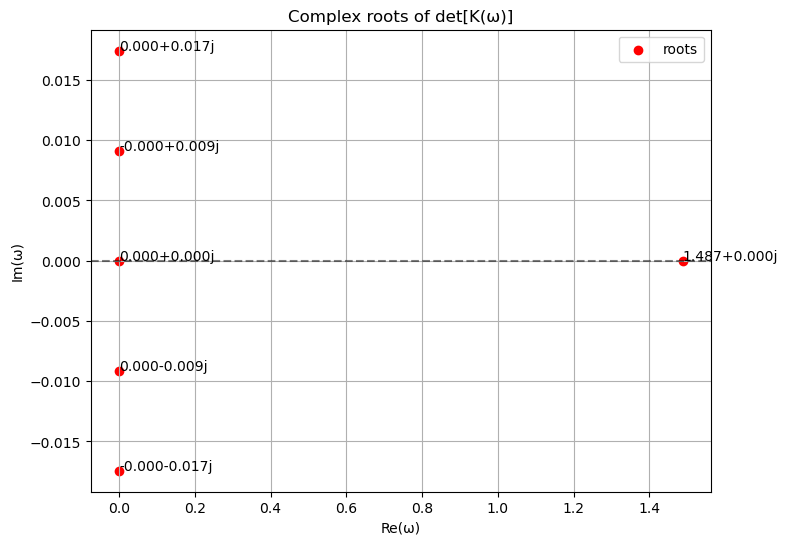

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(omega_grid, f_grid, 'b-', linewidth=1, label='det[K(ω)]')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Mark found roots
for r in omega_n:
    plt.axvline(x=r, color='r', linestyle=':', alpha=0.5)
    plt.plot(r, 0, 'ro', markersize=8)

plt.xlabel('Frequency ω (rad/s)')
plt.ylabel('det[K(ω)]')
plt.title('Determinant of Dynamic Stiffness Matrix')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Found {len(omega_n)} natural frequencies")

# -----------------------------
# Find complex roots of det(K) in the complex ω-plane
# -----------------------------
from scipy.optimize import root

def F_xy(xy):
    om = xy[0] + 1j*xy[1]
    val = detK_numeric(om)
    return [np.real(val), np.imag(val)]

# Grid of initial guesses (adjust ranges if needed)
re_vals = np.linspace(0.1, 5.0, 20)
im_vals = np.linspace(-3.0, 3.0, 25)
roots_complex = []

for xr in re_vals:
    for yi in im_vals:
        guess = [xr, yi]
        try:
            sol = root(F_xy, guess, tol=1e-8, method='hybr')
            if sol.success:
                x,y = sol.x
                omc = x + 1j*y
                res = detK_numeric(omc)
                if abs(res) < 1e-6:
                    # Uniqueness filter
                    if not any(abs(omc - r) < 1e-4 for r in roots_complex):
                        roots_complex.append(omc)
        except Exception:
            pass

roots_complex = np.array(roots_complex)
print('Found complex roots:', roots_complex)

# Plot complex roots in the complex plane
plt.figure(figsize=(8,6))
if roots_complex.size > 0:
    plt.scatter(roots_complex.real, roots_complex.imag, c='r', label='roots')
else:
    plt.text(0.5, 0.5, 'No complex roots found in search region', transform=plt.gca().transAxes)
plt.axhline(0,color='k',linestyle='--',alpha=0.5)
plt.xlabel('Re(ω)')
plt.ylabel('Im(ω)')
plt.title('Complex roots of det[K(ω)]')
plt.grid(True)
plt.legend()
# Annotate only if not too many roots
if roots_complex.size > 0 and roots_complex.size <= 20:
    for omc in roots_complex:
        plt.annotate(f"{omc.real:.3f}{omc.imag:+.3f}j", (omc.real, omc.imag))
plt.show()

### First three natural frequencies and corresponding mode shapes

First three natural frequencies [rad/s]: [ 1.48746533  9.12497622 23.75242512]
First three natural frequencies [Hz]: [0.23673746 1.45228507 3.78031587]


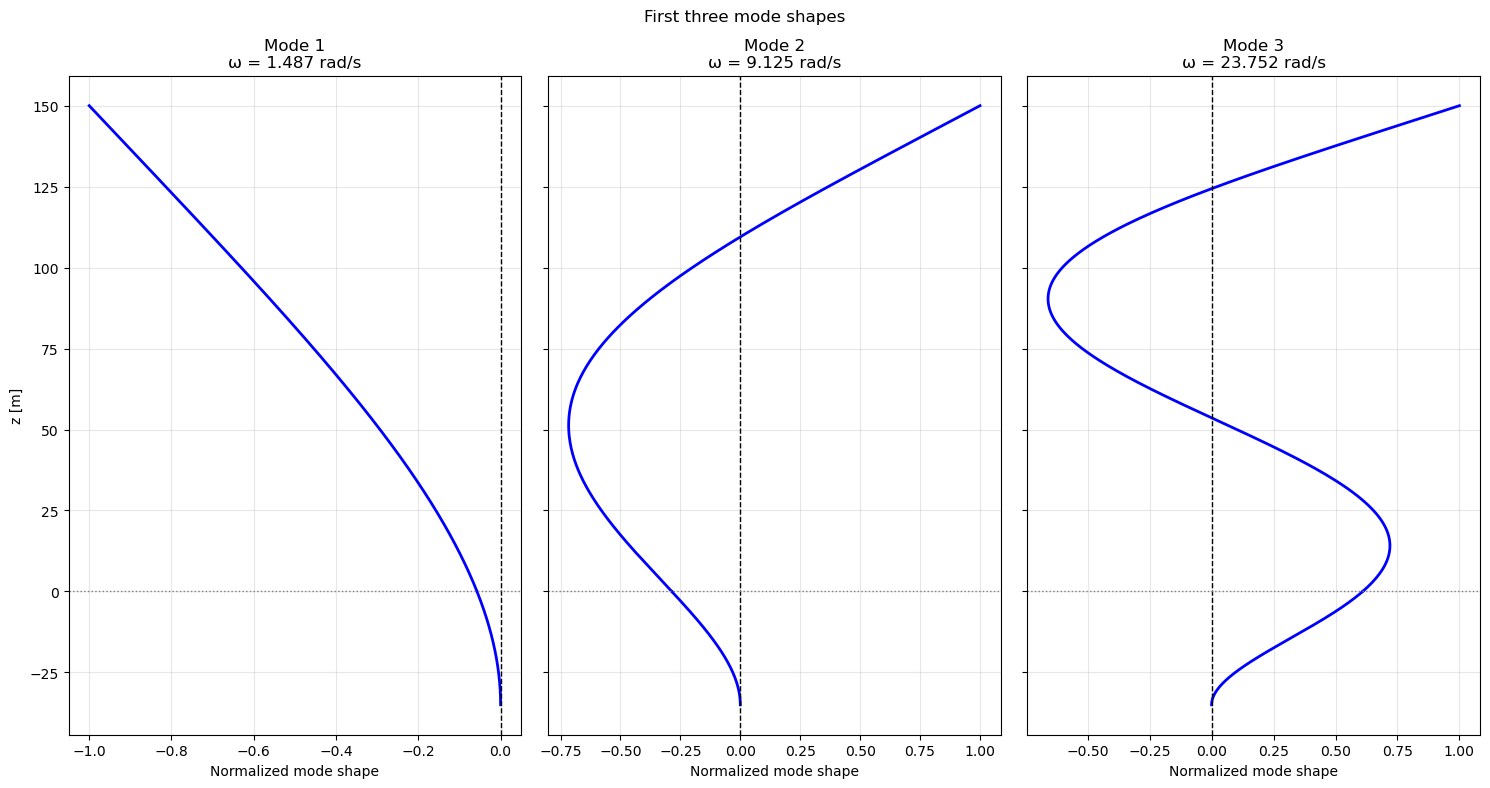

In [153]:
import matplotlib.pyplot as plt

# Select first three non-zero natural frequencies
omega_positive = np.array([om for om in np.real(omega_n) if om > 1e-6], dtype=float)
omega_3 = omega_positive[:3]

print('First three natural frequencies [rad/s]:', omega_3)
print('First three natural frequencies [Hz]:', omega_3/(2*np.pi))

# z-grids for plotting
z1_grid = np.linspace(-h_num, 0.0, 250)    # submerged part
z2_grid = np.linspace(0.0, H_num, 350)     # above-water part

fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

for i, wn in enumerate(omega_3):
    # Compute modal coefficient vector from nullspace approximation of K(wn)
    K_eval = np.array(K_func(wn), dtype=np.complex128)
    _, _, Vh = np.linalg.svd(K_eval)
    Cn = Vh[-1, :]

    subsdict = dict(zip(Cvec, Cn))
    phi1_sym = W1.subs(subsdict).subs(vals).subs(w, float(wn))
    phi2_sym = W2.subs(subsdict).subs(vals).subs(w, float(wn))

    phi1_fun = sp.lambdify(z, phi1_sym, modules='numpy')
    phi2_fun = sp.lambdify(z, phi2_sym, modules='numpy')

    phi1_vals = np.real(np.array(phi1_fun(z1_grid), dtype=np.complex128))
    phi2_vals = np.real(np.array(phi2_fun(z2_grid), dtype=np.complex128))

    # Normalize each mode by global max absolute value
    mode_max = max(np.max(np.abs(phi1_vals)), np.max(np.abs(phi2_vals)))
    if mode_max > 0:
        phi1_vals = phi1_vals / mode_max
        phi2_vals = phi2_vals / mode_max

    ax = axes[i]
    ax.plot(phi1_vals, z1_grid, 'b', linewidth=2)
    ax.plot(phi2_vals, z2_grid, 'b', linewidth=2)
    ax.axvline(0.0, color='k', linestyle='--', linewidth=1)
    ax.axhline(0.0, color='gray', linestyle=':', linewidth=1)
    ax.set_title(f'Mode {i+1}\nω = {wn:.3f} rad/s')
    ax.set_xlabel('Normalized mode shape')
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('z [m]')
fig.suptitle('First three mode shapes', y=0.98)
plt.tight_layout()
plt.show()

### Define wave forcing amplitude for given wave frequency

In [162]:
omega = sp.symbols('omega', positive=True, real=True)
beta_s = sp.symbols('beta_s')
beta = sp.symbols('beta', positive=True, real=True)  # defined via beta^4 = omega^2*rho*A/(E*I)
c_m = sp.symbols('c_m', real=True)
c_a = sp.symbols('c_a', real=True)
c_d = sp.symbols('c_d', real=True)
gamma = sp.Function('gamma')  # gamma(omega)
i = sp.I # imaginary unit
U_x = sp.symbols('U_x')  # could be complex
k = sp.symbols('k', positive=True, real=True)

A21, B21, C21, D21, F21 = sp.symbols('A21 B21 C21 D21 F21')
A22, B22, C22, D22 = sp.symbols('A22 B22 C22 D22')

# --- Parameters from the equations in the figure ---
beta_s4_expr = (1/(E*I)) * (omega**2 * (rho*A + rho_f*c_a*sp.pi*D**2/4) + sp.I*omega/2 * rho_f * c_d * gamma(omega))
beta_s_expr   = omega**2 * rho * A / (E*I)
beta_s_expr = sp.sqrt(beta_s4_expr**(1/4))
beta_expr = sp.sqrt(beta_s_expr**(1/4))

U_x_expression = (- (1/(E*I)) * rho_f*c_m*(sp.pi*D**2/4) * omega**2 * (1/sp.sinh(k*h)) * sp.exp(-sp.I*sp.pi/2)
           + (1/(2*E*I)) * rho_f*c_d*gamma(omega) * omega * (1/sp.sinh(k*h)))
F21 = U_x_expression / (k**4 - beta_s4_expr)

# --- assumed solutions ---
W21 = (A21*sp.cosh(beta_s_expr*z) + B21*sp.sinh(beta_s_expr*z) + C21*sp.cos(beta_s_expr*z) + D21*sp.sin(beta_s_expr*z) + F21*sp.cosh(k*(z + h)))
W22 = (A22*sp.cosh(beta_expr*z)   + B22*sp.sinh(beta_expr*z)   + C22*sp.cos(beta_expr*z)   + D22*sp.sin(beta_expr*z))

# --- Differential equations ---
ode1 = sp.Eq(sp.diff(W21, z, 4) - beta_s4_expr*W21, U_x_expression*sp.cosh(k*(z + h)))
ode2 = sp.Eq(sp.diff(W22, z, 4) - beta_s_expr*W22, 0)

# --- Boundary & interface conditions ---
bc_minh_1 = sp.Eq(W21.subs(z, -h), 0)
bc_minh_2 = sp.Eq(sp.diff(W21, z).subs(z, -h), 0)

# At z = H:  (1.48)-(1.49)
bc_H_1 = sp.Eq(E*I*sp.diff(W22, z, 2).subs(z, H) - J*omega**2*sp.diff(W22, z).subs(z, H), 0)
bc_H_2 = sp.Eq(E*I*sp.diff(W22, z, 3).subs(z, H) - Mtip*omega**2*W22.subs(z, H) + sp.I*omega*c*W22.subs(z, H), 0)

# At z = 0: continuity up to 3rd derivative (1.50)-(1.53)
ic_0_1 = sp.Eq(W21.subs(z, 0), W22.subs(z, 0))
ic_0_2 = sp.Eq(sp.diff(W21, z).subs(z, 0), sp.diff(W22, z).subs(z, 0))
ic_0_3 = sp.Eq(sp.diff(W21, z, 2).subs(z, 0), sp.diff(W22, z, 2).subs(z, 0))
ic_0_4 = sp.Eq(sp.diff(W21, z, 3).subs(z, 0), sp.diff(W22, z, 3).subs(z, 0))

# Collect for convenience
equations = {
    "ode_region1": ode1,
    "ode_region2": ode2,
    "beta_s4": sp.Eq(sp.Symbol('beta_s')**4, beta_s4),
    "beta4": sp.Eq(sp.Symbol('beta')**4, beta4),
    "Ux_expr": sp.Eq(sp.Symbol('U_x'), Ux_expr),
    "bc_z=-h": [bc_minh_1, bc_minh_2],
    "bc_z=H": [bc_H_1, bc_H_2],
    "interface_z=0": [ic_0_1, ic_0_2, ic_0_3, ic_0_4],
}

# Print a couple of them if you want
for kname, eq in equations.items():
    print("\n---", kname, "---")
    print(eq)






--- ode_region1 ---
Eq(0.5*A21*omega**0.5*(2*I*c_d*rho_f*gamma(omega) + omega*(4*A*rho + pi*D**2*c_a*rho_f))**0.5*cosh(0.840896415253715*omega**0.125*z*(2*I*c_d*rho_f*gamma(omega) + omega*(4*A*rho + pi*D**2*c_a*rho_f))**0.125/(E**0.125*I**0.125))/(E**0.5*I**0.5) + 0.5*B21*omega**0.5*(2*I*c_d*rho_f*gamma(omega) + omega*(4*A*rho + pi*D**2*c_a*rho_f))**0.5*sinh(0.840896415253715*omega**0.125*z*(2*I*c_d*rho_f*gamma(omega) + omega*(4*A*rho + pi*D**2*c_a*rho_f))**0.125/(E**0.125*I**0.125))/(E**0.5*I**0.5) + 0.5*C21*omega**0.5*(2*I*c_d*rho_f*gamma(omega) + omega*(4*A*rho + pi*D**2*c_a*rho_f))**0.5*cos(0.840896415253715*omega**0.125*z*(2*I*c_d*rho_f*gamma(omega) + omega*(4*A*rho + pi*D**2*c_a*rho_f))**0.125/(E**0.125*I**0.125))/(E**0.5*I**0.5) + 0.5*D21*omega**0.5*(2*I*c_d*rho_f*gamma(omega) + omega*(4*A*rho + pi*D**2*c_a*rho_f))**0.5*sin(0.840896415253715*omega**0.125*z*(2*I*c_d*rho_f*gamma(omega) + omega*(4*A*rho + pi*D**2*c_a*rho_f))**0.125/(E**0.125*I**0.125))/(E**0.5*I**0.5) + k**4*omega

In [ ]:
omega = 2 * np.pi / 12
def dispersion(k):
    return omega**2 - g*k*np.tanh(k*h_num)

k = fsolve(dispersion, omega**2 / g)[0]
print(f"Wave number k for frequency {omega:.3f} rad/s: {k:.6f} 1/m")

Wave number k for frequency 0.524 rad/s: 0.033756 1/m
